## Can an animal's adoption rate be predicted by its description provided in Petfinder.com?

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble 
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


nlp = spacy.load('en')


In [4]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [3]:
# Read in files
df_all = pd.read_csv(r'C:\Users\julia\Dropbox\Data Science 2\Petfinder\train.csv')
df_text=df_all[['AdoptionSpeed','Description']]
df_text=df_text.dropna()
df_text.groupby('AdoptionSpeed').count()

,Description
AdoptionSpeed,
0,410
1,3088
2,4032
3,3258
4,4193


In [5]:
# Combine adoption speeds 0 and 1 to balance classes
df_text['AdoptionSpeed'].replace(0,1,inplace=True)
df_text.groupby('AdoptionSpeed').count()

,Description
AdoptionSpeed,
1,3498
2,4032
3,3258
4,4193


In [6]:
# Drop animals without descriptions
index=df_all['Description'].index[df_all['Description'].apply(pd.isnull)]
df_all.drop(index,0,inplace=True)
df_all.shape

(14981, 24)

In [7]:
# Clean text to remove any punctuation and stop words and convert all text to lower case

corpus = []
for i, description in enumerate(df_text['Description']):
    desc = re.sub('[^a-zA-Z]',' ',description)
    desc = desc.lower()
    desc = desc.split()
    desc = [word for word in desc if not word in set(stopwords.words('english'))]
    desc = ' '.join(desc)
    corpus.append(desc)

df_text = df_text.join(pd.DataFrame({'clean':corpus}))
df_text.dropna(inplace=True)

In [8]:
# Create function to tokenize, remove stop words and convert to lowercase
# Adapted from https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

import string
stop_words = spacy.lang.en.stop_words.STOP_WORDS
from spacy.lang.en import English
punctuations = string.punctuation

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [9]:
# Set up BOW
cv = CountVectorizer(max_features=2000,tokenizer = spacy_tokenizer, ngram_range=(1,1))
X_bow = cv.fit_transform(df_text['clean']).toarray()
y_bow = df_text.iloc[:,0].values
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow,y_bow,test_size=0.25)

In [10]:
df_text.to_pickle('df_text.pkl')

### Try KMeans Clustering on BOW

In [11]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4)
km.fit(X_bow)
clusters = km.labels_.tolist()
df_text['cluster']= clusters
df_text['cluster'].value_counts() 

0    8575
1    4316
3    1257
2     821
Name: cluster, dtype: int64

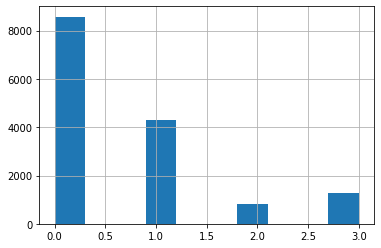

In [12]:
df_text['cluster'].hist()

#### There does not appear to be a correlation of the clusters with the adoption speed:

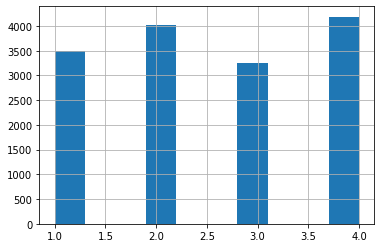

In [13]:
df_text['AdoptionSpeed'].hist()

In [14]:
vectorizer = TfidfVectorizer()
test_df = df_text[:5000].copy()
X_tfidf=vectorizer.fit_transform(test_df['Description'])
y=test_df.iloc[:,0].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.25)

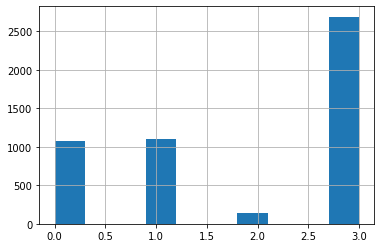

In [19]:
'''km.fit(X_tfidf)
clusters = km.labels_.tolist()
df_text['cluster tfidf']= clusters
df_text['cluster tfidf'].hist()'''

test_df['cluster tfidf']= clusters
test_df['cluster tfidf'].hist()

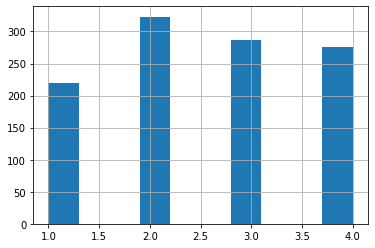

In [21]:
#df_text[df_text['cluster tfidf']==1]['AdoptionSpeed'].hist()
test_df[test_df['cluster tfidf']==1]['AdoptionSpeed'].hist()

In [22]:
#confusion_matrix(y,df_text['cluster'])
confusion_matrix(y,test_df['cluster'])

array([[  0,   0,   0,   0,   0],
       [628, 342,  76,  90,   0],
       [766, 405,  75, 110,   0],
       [653, 298,  50,  84,   0],
       [830, 399,  77, 117,   0]], dtype=int64)

In [24]:
from sklearn import metrics
#metrics.adjusted_rand_score(y, df_text['cluster'])
#metrics.silhouette_score(y.reshape(-1, 1),df_text['cluster'])

metrics.silhouette_score(y.reshape(-1, 1),test_df['cluster'])

-0.021296748166270328

### Try random forest:

In [25]:
rfc = ensemble.RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_bow, y_train_bow)
y_pred = rfc.predict(X_test_bow)
print(rfc.score(X_test_bow, y_test_bow))
print(confusion_matrix(y_pred,y_test_bow))

0.2575474218541277
[[224 256 245 264]
 [257 298 260 307]
 [138 163 120 171]
 [221 271 226 322]]


In [26]:
rfc.fit(X_train_tfidf, y_train_tfidf)
y_pred = rfc.predict(X_test_tfidf)
print(rfc.score(X_test_tfidf, y_test_tfidf))
print(confusion_matrix(y_pred,y_test_tfidf))

0.336
[[ 86  88  68  89]
 [ 83 129  82  91]
 [ 28  46  57  33]
 [ 71  83  68 148]]


### Try Latent Semantic Analysis 

In [31]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 79.43516706343476


In [33]:
X_test_lsa = lsa.fit_transform(X_test_tfidf)

In [35]:
rfc.fit(X_train_lsa, y_train_tfidf)
y_pred = rfc.predict(X_test_lsa)
print(rfc.score(X_test_lsa, y_test_tfidf))

0.228


#### Try Latent Dirichlet Allocation

In [36]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=5,random_state=42)
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(df_text['clean'])

In [37]:
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [38]:
len(LDA.components_)

5

In [39]:
topic_results = LDA.transform(dtm)

In [40]:
df_text['Topic'] = topic_results.argmax(axis=1)

In [41]:
top_word_indices = LDA.components_[0].argsort()[-10:]
for index in top_word_indices:
    print(cv.get_feature_names()[index])

time
cat
food
like
playful
little
old
kitten
home
loves


In [42]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['play', 'months', 'love', 'adoption', 'cats', 'time', 'cat', 'food', 'like', 'playful', 'little', 'old', 'kitten', 'home', 'loves']


THE TOP 15 WORDS FOR TOPIC #1
['nak', 'tak', 'ada', 'anak', 'boleh', 'manja', 'yg', 'ni', 'untuk', 'di', 'yang', 'dia', 'dan', 'kucing', 'saya']


THE TOP 15 WORDS FOR TOPIC #2
['good', 'cute', 'rescued', 'pls', 'female', 'dog', 'looking', 'old', 'adopt', 'interested', 'puppies', 'contact', 'adoption', 'puppy', 'home']


THE TOP 15 WORDS FOR TOPIC #3
['like', 'need', 'adoption', 'mother', 'new', 'love', 'food', 'adopt', 'house', 'care', 'kitten', 'cats', 'home', 'kittens', 'cat']


THE TOP 15 WORDS FOR TOPIC #4
['active', 'loves', 'needs', 'playful', 'family', 'new', 'looking', 'love', 'friendly', 'dogs', 'owner', 'loving', 'good', 'home', 'dog']




#### Try Non-negative Matrix Factorization

In [43]:
nmf_model = NMF(n_components=4,random_state=42)
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [44]:
top_word_indices = nmf_model.components_[0].argsort()[-10:]
for index in top_word_indices:
    print(cv.get_feature_names()[index])

time
family
puppies
adopt
owner
house
good
adoption
dogs
dog


In [45]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['isolated', '3cutie', 'join', 'energetic', 'bloomed', 'sheru', 'doe', 'notification', '33', 'melbourne', 'gain', 'fairer', '3kgs', 'curiosity', 'curable']


THE TOP 15 WORDS FOR TOPIC #1
['gain', 'simpan', 'sheru', 'lexii', 'bloomed', 'moved', 'jantina', 'isolated', 'mase', 'eecho', '3kgs', 'hyper', 'bonnet', 'hyped', 'bolehlah']


THE TOP 15 WORDS FOR TOPIC #2
['location', 'taco', 'bcs', 'scratched', '24th', 'action', 'kucen', 'lucky', 'soyoung', 'contacts', 'switch', 'contagious', 'impossible', 'clown', 'playbite']


THE TOP 15 WORDS FOR TOPIC #3
['notification', 'passerby', 'japanese', 'mase', 'loyal', 'eldery', '33', 'guinea', 'join', 'nourished', 'chaining', 'fairer', 'jimbo', 'joseph', 'frosty']




In [46]:
df_text['Topic NMF']= topic_results.argmax(axis=1)

In [47]:
df_text[['Description','AdoptionSpeed', 'Topic NMF']].head(20)

,Description,AdoptionSpeed,Topic NMF
0,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,I just found it alone yesterday near my apartm...,1,3
2,Their pregnant mother was dumped by her irresp...,3,2
3,"Good guard dog, very alert, active, obedience ...",2,4
4,This handsome yet cute boy is up for adoption....,2,2
5,This is a stray kitten that came to my house. ...,2,3
6,anyone within the area of ipoh or taiping who ...,1,3
7,Siu Pak just give birth on 13/6/10 to 6puppies...,3,2
8,"healthy and active, feisty kitten found in nei...",1,3
9,"Very manja and gentle stray cat found, we woul...",4,3


#### Try SVC

In [49]:
from sklearn.svm import LinearSVC
svc=LinearSVC()
svc.fit(X_train_bow, y_train_bow)
y_pred = svc.predict(X_test_bow)
svc.score(X_test_bow, y_test_bow)

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.25567726422655623

#### Try sentiment analysis

In [50]:
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [51]:
df_text['scores'] = df_text['Description'].apply(lambda review: sid.polarity_scores(review))
df_text['compound']  = df_text['scores'].apply(lambda score_dict: score_dict['compound'])

df_text.head()

,AdoptionSpeed,Description,clean,cluster,Topic,Topic NMF,scores,compound
0,2,Nibble is a 3+ month old ball of cuteness. He ...,nibble month old ball cuteness energetic playf...,0,0,0,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp...",0.9552
1,1,I just found it alone yesterday near my apartm...,found alone yesterday near apartment shaking b...,0,3,3,"{'neg': 0.149, 'neu': 0.723, 'pos': 0.129, 'co...",0.1280
2,3,Their pregnant mother was dumped by her irresp...,pregnant mother dumped irresponsible owner roa...,1,2,2,"{'neg': 0.095, 'neu': 0.706, 'pos': 0.2, 'comp...",0.7650
3,2,"Good guard dog, very alert, active, obedience ...",good guard dog alert active obedience waiting ...,0,4,4,"{'neg': 0.0, 'neu': 0.483, 'pos': 0.517, 'comp...",0.9538
4,2,This handsome yet cute boy is up for adoption....,handsome yet cute boy adoption playful pal see...,1,2,2,"{'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'comp...",0.9880


In [105]:
df_text.head(25)

,AdoptionSpeed,Description,clean,cluster,Topic,Topic NMF,scores,compound,binary
0,2,Nibble is a 3+ month old ball of cuteness. He ...,nibble month old ball cuteness energetic playf...,0,0,0,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp...",0.9552,0
1,1,I just found it alone yesterday near my apartm...,found alone yesterday near apartment shaking b...,0,3,3,"{'neg': 0.149, 'neu': 0.723, 'pos': 0.129, 'co...",0.1280,0
2,3,Their pregnant mother was dumped by her irresp...,pregnant mother dumped irresponsible owner roa...,1,2,2,"{'neg': 0.095, 'neu': 0.706, 'pos': 0.2, 'comp...",0.7650,1
3,2,"Good guard dog, very alert, active, obedience ...",good guard dog alert active obedience waiting ...,0,4,4,"{'neg': 0.0, 'neu': 0.483, 'pos': 0.517, 'comp...",0.9538,0
4,2,This handsome yet cute boy is up for adoption....,handsome yet cute boy adoption playful pal see...,1,2,2,"{'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'comp...",0.9880,0
5,2,This is a stray kitten that came to my house. ...,stray kitten came house feeding cannot keep,0,3,3,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0
6,1,anyone within the area of ipoh or taiping who ...,anyone within area ipoh taiping interested ado...,0,3,3,"{'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp...",0.9116,0
7,3,Siu Pak just give birth on 13/6/10 to 6puppies...,siu pak give birth puppies interested pls call...,0,2,2,"{'neg': 0.0, 'neu': 0.818, 'pos': 0.182, 'comp...",0.4588,1
8,1,"healthy and active, feisty kitten found in nei...",healthy active feisty kitten found neighbours ...,0,3,3,"{'neg': 0.113, 'neu': 0.576, 'pos': 0.311, 'co...",0.5327,0
9,4,"Very manja and gentle stray cat found, we woul...",manja gentle stray cat found would really like...,1,3,3,"{'neg': 0.0, 'neu': 0.751, 'pos': 0.249, 'comp...",0.8916,1


In [52]:
X = np.array(df_text[['compound']])
y = df_text.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [53]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.28052364413572

In [54]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
xgb.score(X_test, y_test)

0.279722148009618

### Try converting to binary:

In [55]:
df_text['binary']= np.where(df_text.AdoptionSpeed<3, 0, 1)

In [56]:
df_text['binary'].value_counts()

0    7527
1    7442
Name: binary, dtype: int64

In [57]:
# Set up BOW
y_bow_bin = df_text['binary'].values
X_train_bow_bin, X_test_bow_bin, y_train_bow_bin, y_test_bow_bin = train_test_split(X_bow,y_bow_bin,test_size=0.25)

In [58]:
rfc.fit(X_train_bow_bin, y_train_bow_bin)
y_pred = rfc.predict(X_test_bow_bin)
print(rfc.score(X_test_bow_bin, y_test_bow_bin))
print(confusion_matrix(y_pred,y_test_bow_bin))

0.5076142131979695
[[1083 1036]
 [ 807  817]]


In [60]:
lr = LogisticRegression()
lr.fit(X_train_bow_bin,y_train_bow_bin)
pred_lasso = lr.predict(X_test_bow_bin)
y_pred = lr.predict(X_test_bow_bin)
print(lr.score(X_test_bow_bin, y_test_bow_bin))
print(confusion_matrix(y_pred,y_test_bow_bin))

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.49585893668180603
[[967 964]
 [923 889]]


In [61]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_bow_bin,y_train_bow_bin)
y_pred = xgb.predict(X_test_bow_bin)
xgb.score(X_test_bow_bin, y_test_bow_bin)

0.499599251936949

### Try to correlate words with age using puppy, kitten, and young

In [71]:
cv = CountVectorizer(max_features=2000,tokenizer = spacy_tokenizer, ngram_range=(1,1))
X_bow = cv.fit_transform(df_text['clean']).toarray()

data_dtm = pd.DataFrame(X_bow, columns=cv.get_feature_names())
data_dtm.index = df_text.index

In [72]:
data_dtm.head()

,2,3,abandon,abit,able,absolutely,abt,abuse,accept,accident,...,year,yearly,yellow,yes,yesterday,yg,yo,young,yr,﻿1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [73]:
cols=cv.get_feature_names()

In [75]:
age_cols = data_dtm[['kitten','puppy','young']]

In [76]:
age_cols['Age']=df_all['Age'].copy()

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
age_cols.head()

,kitten,puppy,young,Age
0,0,0,0,3
1,0,0,0,1
2,0,1,0,1
3,0,0,0,4
4,0,1,1,1


In [78]:
from sklearn.linear_model import LinearRegression
X=age_cols.drop('Age',1)
y=age_cols['Age'].values

In [79]:
lin = LinearRegression()
lin.fit(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [80]:
lin.score(X, y)

0.0001904137872689171

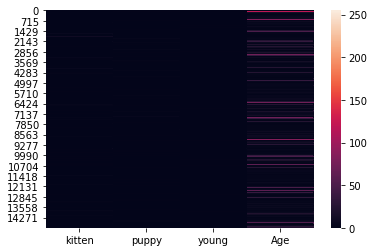

In [81]:
corr_mat = age_cols.corr()
sns.heatmap(age_cols)

In [83]:
X=age_cols.drop('Age',1)
y=df_text['AdoptionSpeed'].values
rfc.fit(X, y)
rfc.score(X, y)

0.28766116641058187

### Hyperparameter tuning

In [93]:
vectorizer = TfidfVectorizer(max_features=2000,tokenizer = spacy_tokenizer, ngram_range=(1,1))
test_df = df_text[:5000].copy()
X_tfidf=vectorizer.fit_transform(test_df['clean'])
y=test_df.iloc[:,0].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.25)

In [94]:
rfc.fit(X_train_tfidf, y_train_tfidf)
rfc.score(X_test_tfidf, y_test_tfidf)

0.244

In [95]:
# Test ngrams

vectorizer = TfidfVectorizer(max_features=2000,tokenizer = spacy_tokenizer, ngram_range=(1,2))
X_tfidf=vectorizer.fit_transform(test_df['clean'])
y=test_df.iloc[:,0].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.25)

rfc.fit(X_train_tfidf, y_train_tfidf)
rfc.score(X_test_tfidf, y_test_tfidf)

0.2608

In [98]:
vectorizer = TfidfVectorizer(max_features=2000,tokenizer = spacy_tokenizer, ngram_range=(1,3))
test_df = df_text[:5000].copy()
X_tfidf=vectorizer.fit_transform(test_df['clean'])
y=test_df.iloc[:,0].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.25)

rfc.fit(X_train_tfidf, y_train_tfidf)
rfc.score(X_test_tfidf, y_test_tfidf)

0.26

In [99]:
# Vary max_features
vectorizer = TfidfVectorizer(max_features=3000,tokenizer = spacy_tokenizer, ngram_range=(1,2))
X_tfidf=vectorizer.fit_transform(test_df['clean'])
y=test_df.iloc[:,0].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.25)

rfc.fit(X_train_tfidf, y_train_tfidf)
rfc.score(X_test_tfidf, y_test_tfidf)

0.2544

In [100]:
# Vary max_features
vectorizer = TfidfVectorizer(max_features=1000,tokenizer = spacy_tokenizer, ngram_range=(1,2))
X_tfidf=vectorizer.fit_transform(test_df['clean'])
y=test_df.iloc[:,0].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.25)

rfc.fit(X_train_tfidf, y_train_tfidf)
rfc.score(X_test_tfidf, y_test_tfidf)

0.284

In [101]:
# Vary max_features
vectorizer = TfidfVectorizer(max_features=500,tokenizer = spacy_tokenizer, ngram_range=(1,2))
X_tfidf=vectorizer.fit_transform(test_df['clean'])
y=test_df.iloc[:,0].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.25)

rfc.fit(X_train_tfidf, y_train_tfidf)
rfc.score(X_test_tfidf, y_test_tfidf)

0.2352

In [102]:
# Change stop words  
vectorizer = TfidfVectorizer(max_features=1000,tokenizer = spacy_tokenizer, ngram_range=(1,2), stop_words="english")
X_tfidf=vectorizer.fit_transform(test_df['clean'])
y=test_df.iloc[:,0].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.25)

rfc.fit(X_train_tfidf, y_train_tfidf)
rfc.score(X_test_tfidf, y_test_tfidf)

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.2592

In [104]:
# Try best parameters on entire dataset
vectorizer = TfidfVectorizer(max_features=1000,tokenizer = spacy_tokenizer, ngram_range=(1,2))
X_tfidf=vectorizer.fit_transform(df_text['clean'])
y=df_text.iloc[:,0].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y,test_size=0.25)

rfc.fit(X_train_tfidf, y_train_tfidf)
rfc.score(X_test_tfidf, y_test_tfidf)

0.26342506011220945

In [84]:
df_1=df_text[df_text['AdoptionSpeed']==1].copy()
df_2=df_text[df_text['AdoptionSpeed']==2].copy()
df_3=df_text[df_text['AdoptionSpeed']==3].copy()
df_4=df_text[df_text['AdoptionSpeed']==4].copy()

df_1.dropna(inplace=True)
df_2.dropna(inplace=True)
df_3.dropna(inplace=True)
df_4.dropna(inplace=True)

In [85]:
cv = CountVectorizer(stop_words='english',max_features=100)
data_cv_1 = cv.fit_transform(df_1.clean)
data_dtm_1 = pd.DataFrame(data_cv_1.toarray(), columns=cv.get_feature_names())
data_dtm_1.index = df_1.index

cv = CountVectorizer(stop_words='english',max_features=100)
data_cv_2 = cv.fit_transform(df_2.clean)
data_dtm_2 = pd.DataFrame(data_cv_2.toarray(), columns=cv.get_feature_names())
data_dtm_2.index = df_2.index

cv = CountVectorizer(stop_words='english',max_features=100)
data_cv_3 = cv.fit_transform(df_3.clean)
data_dtm_3 = pd.DataFrame(data_cv_3.toarray(), columns=cv.get_feature_names())
data_dtm_3.index = df_3.index

cv = CountVectorizer(stop_words='english',max_features=100)
data_cv_4 = cv.fit_transform(df_4.clean)
data_dtm_4 = pd.DataFrame(data_cv_4.toarray(), columns=cv.get_feature_names())
data_dtm_4.index = df_4.index


In [86]:
top1 = data_dtm_1.sum().sort_values(ascending=False).head(25)
top2 = data_dtm_2.sum().sort_values(ascending=False).head(25)
top3 = data_dtm_3.sum().sort_values(ascending=False).head(25)
top4 = data_dtm_4.sum().sort_values(ascending=False).head(25)

In [87]:
top_words1 = list(top1.index)
top_words2 = list(top2.index)
top_words3 =list(top3.index)
top_words4 = list(top4.index)

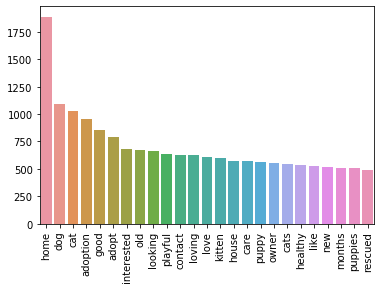

In [88]:
sns.barplot(x=top_words1,y=top1)
plt.xticks(rotation='vertical')
plt.show()

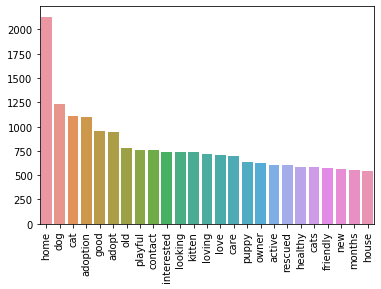

In [89]:
sns.barplot(x=top_words2,y=top2)
plt.xticks(rotation='vertical')
plt.show()

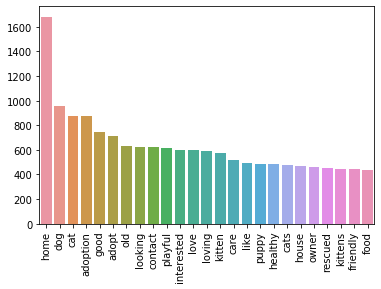

In [90]:
sns.barplot(x=top_words3,y=top3)
plt.xticks(rotation='vertical')
plt.show()

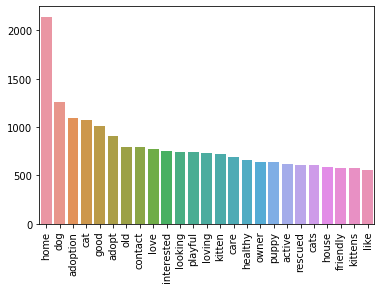

In [91]:
sns.barplot(x=top_words4,y=top4)
plt.xticks(rotation='vertical')
plt.show()